In [1]:
import pandas as pd
import numpy as np
import os
import sys

# !pip install librosa
# !pip install lifelines
# !pip install np_utils
# !pip install tensorflow

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt


import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

In [2]:
#Import the dataset to use
landmarks_df = pd.read_csv('outputs/demo_landmarks.csv')
landmarks_df

,Unnamed: 0,index,label,landmark_1_x,landmark_1_y,landmark_1_z,landmark_2_x,landmark_2_y,landmark_2_z,landmark_3_x,...,landmark_475_z,landmark_476_x,landmark_476_y,landmark_476_z,landmark_477_x,landmark_477_y,landmark_477_z,landmark_478_x,landmark_478_y,landmark_478_z
0,0,0,happy,0.507577,0.690504,-0.067539,0.496229,0.623151,-0.169093,0.502712,...,-0.007745,0.644046,0.382131,-0.007746,0.616720,0.409790,-0.007778,0.648537,0.432745,-0.007774
1,1,1,happy,0.506913,0.685366,-0.056324,0.531459,0.619465,-0.139276,0.513914,...,0.030370,0.604874,0.417298,0.030375,0.580915,0.438486,0.030342,0.605856,0.459424,0.030347
2,2,2,happy,0.529042,0.675124,-0.048689,0.521464,0.605306,-0.131408,0.522370,...,0.001254,0.629228,0.374716,0.001255,0.608027,0.400481,0.001223,0.634681,0.421634,0.001229
3,3,3,happy,0.599993,0.747104,-0.070677,0.613960,0.620251,-0.156688,0.594227,...,0.073009,0.664438,0.387820,0.073013,0.648348,0.409021,0.072974,0.671501,0.424706,0.072984
4,4,4,happy,0.493806,0.719292,-0.075153,0.504832,0.598530,-0.145169,0.502998,...,0.028723,0.658979,0.422724,0.028730,0.630458,0.440460,0.028699,0.653501,0.464135,0.028702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13571,13571,13571,neutral,0.504123,0.720507,-0.046975,0.509277,0.640532,-0.119010,0.507253,...,-0.003078,0.620796,0.442554,-0.003075,0.599171,0.462500,-0.003106,0.620639,0.481957,-0.003103
13572,13572,13572,neutral,0.497067,0.734362,-0.066890,0.482076,0.643645,-0.148767,0.489366,...,-0.016498,0.646841,0.384284,-0.016496,0.616515,0.414354,-0.016534,0.647837,0.443698,-0.016528
13573,13573,13573,neutral,0.495357,0.695052,-0.030546,0.516039,0.628310,-0.141734,0.505505,...,-0.001490,0.661572,0.363049,-0.001487,0.627144,0.388726,-0.001521,0.656633,0.417313,-0.001518
13574,13574,13574,neutral,0.515543,0.673966,-0.084770,0.523678,0.591117,-0.129465,0.516794,...,0.054924,0.620038,0.450670,0.054927,0.594984,0.468980,0.054898,0.617746,0.490170,0.054905


In [3]:
#Check the range of landmarks obtained (Verify if normalized already)

In [4]:
#Get the inputs (All landmarks)
x_landmarks_df = landmarks_df.iloc[:,3:]
x_landmarks_df

,landmark_1_x,landmark_1_y,landmark_1_z,landmark_2_x,landmark_2_y,landmark_2_z,landmark_3_x,landmark_3_y,landmark_3_z,landmark_4_x,...,landmark_475_z,landmark_476_x,landmark_476_y,landmark_476_z,landmark_477_x,landmark_477_y,landmark_477_z,landmark_478_x,landmark_478_y,landmark_478_z
0,0.507577,0.690504,-0.067539,0.496229,0.623151,-0.169093,0.502712,0.643993,-0.086510,0.467229,...,-0.007745,0.644046,0.382131,-0.007746,0.616720,0.409790,-0.007778,0.648537,0.432745,-0.007774
1,0.506913,0.685366,-0.056324,0.531459,0.619465,-0.139276,0.513914,0.632298,-0.069509,0.504124,...,0.030370,0.604874,0.417298,0.030375,0.580915,0.438486,0.030342,0.605856,0.459424,0.030347
2,0.529042,0.675124,-0.048689,0.521464,0.605306,-0.131408,0.522370,0.623367,-0.064017,0.490133,...,0.001254,0.629228,0.374716,0.001255,0.608027,0.400481,0.001223,0.634681,0.421634,0.001229
3,0.599993,0.747104,-0.070677,0.613960,0.620251,-0.156688,0.594227,0.654728,-0.082240,0.557118,...,0.073009,0.664438,0.387820,0.073013,0.648348,0.409021,0.072974,0.671501,0.424706,0.072984
4,0.493806,0.719292,-0.075153,0.504832,0.598530,-0.145169,0.502998,0.630493,-0.080717,0.485267,...,0.028723,0.658979,0.422724,0.028730,0.630458,0.440460,0.028699,0.653501,0.464135,0.028702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13571,0.504123,0.720507,-0.046975,0.509277,0.640532,-0.119010,0.507253,0.659203,-0.054190,0.487693,...,-0.003078,0.620796,0.442554,-0.003075,0.599171,0.462500,-0.003106,0.620639,0.481957,-0.003103
13572,0.497067,0.734362,-0.066890,0.482076,0.643645,-0.148767,0.489366,0.668186,-0.069688,0.457620,...,-0.016498,0.646841,0.384284,-0.016496,0.616515,0.414354,-0.016534,0.647837,0.443698,-0.016528
13573,0.495357,0.695052,-0.030546,0.516039,0.628310,-0.141734,0.505505,0.636442,-0.051140,0.499278,...,-0.001490,0.661572,0.363049,-0.001487,0.627144,0.388726,-0.001521,0.656633,0.417313,-0.001518
13574,0.515543,0.673966,-0.084770,0.523678,0.591117,-0.129465,0.516794,0.622345,-0.076262,0.497495,...,0.054924,0.620038,0.450670,0.054927,0.594984,0.468980,0.054898,0.617746,0.490170,0.054905


In [5]:
import sklearn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

#Get the labels
y_landmarks_df = landmarks_df['label']

encoder = OneHotEncoder()
y_landmarks_df = encoder.fit_transform(np.array(y_landmarks_df).reshape(-1,1)).toarray()

y_landmarks_df

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [6]:
#Split the dataset to training and test sets (80% training, 20% test)
num_rows = x_landmarks_df.shape[0]
test_size = int(num_rows * 0.2)
train_size = num_rows - test_size


X_test = pd.DataFrame()
X_train = pd.DataFrame()
y_test = []
y_train = []
num_rows, train_size, test_size

(13576, 10861, 2715)

In [7]:
dup_df = x_landmarks_df[x_landmarks_df.duplicated(keep=False)]
dup_df

,landmark_1_x,landmark_1_y,landmark_1_z,landmark_2_x,landmark_2_y,landmark_2_z,landmark_3_x,landmark_3_y,landmark_3_z,landmark_4_x,...,landmark_475_z,landmark_476_x,landmark_476_y,landmark_476_z,landmark_477_x,landmark_477_y,landmark_477_z,landmark_478_x,landmark_478_y,landmark_478_z
0,0.507577,0.690504,-0.067539,0.496229,0.623151,-0.169093,0.502712,0.643993,-0.086510,0.467229,...,-0.007745,0.644046,0.382131,-0.007746,0.616720,0.409790,-0.007778,0.648537,0.432745,-0.007774
1,0.506913,0.685366,-0.056324,0.531459,0.619465,-0.139276,0.513914,0.632298,-0.069509,0.504124,...,0.030370,0.604874,0.417298,0.030375,0.580915,0.438486,0.030342,0.605856,0.459424,0.030347
2,0.529042,0.675124,-0.048689,0.521464,0.605306,-0.131408,0.522370,0.623367,-0.064017,0.490133,...,0.001254,0.629228,0.374716,0.001255,0.608027,0.400481,0.001223,0.634681,0.421634,0.001229
3,0.599993,0.747104,-0.070677,0.613960,0.620251,-0.156688,0.594227,0.654728,-0.082240,0.557118,...,0.073009,0.664438,0.387820,0.073013,0.648348,0.409021,0.072974,0.671501,0.424706,0.072984
4,0.493806,0.719292,-0.075153,0.504832,0.598530,-0.145169,0.502998,0.630493,-0.080717,0.485267,...,0.028723,0.658979,0.422724,0.028730,0.630458,0.440460,0.028699,0.653501,0.464135,0.028702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13571,0.504123,0.720507,-0.046975,0.509277,0.640532,-0.119010,0.507253,0.659203,-0.054190,0.487693,...,-0.003078,0.620796,0.442554,-0.003075,0.599171,0.462500,-0.003106,0.620639,0.481957,-0.003103
13572,0.497067,0.734362,-0.066890,0.482076,0.643645,-0.148767,0.489366,0.668186,-0.069688,0.457620,...,-0.016498,0.646841,0.384284,-0.016496,0.616515,0.414354,-0.016534,0.647837,0.443698,-0.016528
13573,0.495357,0.695052,-0.030546,0.516039,0.628310,-0.141734,0.505505,0.636442,-0.051140,0.499278,...,-0.001490,0.661572,0.363049,-0.001487,0.627144,0.388726,-0.001521,0.656633,0.417313,-0.001518
13574,0.515543,0.673966,-0.084770,0.523678,0.591117,-0.129465,0.516794,0.622345,-0.076262,0.497495,...,0.054924,0.620038,0.450670,0.054927,0.594984,0.468980,0.054898,0.617746,0.490170,0.054905


In [8]:
#765 IS UNIQUE
(x_landmarks_df == x_landmarks_df.iloc[765]).all(axis=1).sum()

1

In [9]:
test_indices = np.array([test_size,])
y_test = np.array([test_size,])

def generate_index():
    while True:
        random_index = randint(0, num_rows - 1)

        #TEST1: index should not be in test_indices already
        if test_indices[np.isin(test_indices, [random_index])].size == 0:
            #UNIQUE INDEX FOUND HERE
            #TEST 2: records in the index SHOULD NOT HAVE MORE THAN 1 RECORD in landmarks
            random_test = x_landmarks_df.iloc[random_index]
            if (dup_df == random_test).all(axis=1).sum() == 0:
                return random_index
    

In [10]:
from random import randint


test_indices_tmp = []
y_test_tmp = []
for i in range(0, test_size):
    random_index = generate_index()
    test_indices_tmp.append(random_index)
    y_test_tmp.append(y_landmarks_df[random_index])
    
    test_indices = np.array(test_indices_tmp)
    y_test = np.array(y_test_tmp)

X_test = pd.concat([X_test, x_landmarks_df.iloc[test_indices]])
y_test = np.array(y_test)

In [11]:
train_indices = np.delete(np.arange(num_rows), test_indices, axis=0)

X_train = pd.concat([X_train, x_landmarks_df.iloc[train_indices]])
y_train = np.delete(y_landmarks_df, test_indices, axis=0)

In [12]:
X_train

,landmark_1_x,landmark_1_y,landmark_1_z,landmark_2_x,landmark_2_y,landmark_2_z,landmark_3_x,landmark_3_y,landmark_3_z,landmark_4_x,...,landmark_475_z,landmark_476_x,landmark_476_y,landmark_476_z,landmark_477_x,landmark_477_y,landmark_477_z,landmark_478_x,landmark_478_y,landmark_478_z
0,0.507577,0.690504,-0.067539,0.496229,0.623151,-0.169093,0.502712,0.643993,-0.086510,0.467229,...,-0.007745,0.644046,0.382131,-0.007746,0.616720,0.409790,-0.007778,0.648537,0.432745,-0.007774
1,0.506913,0.685366,-0.056324,0.531459,0.619465,-0.139276,0.513914,0.632298,-0.069509,0.504124,...,0.030370,0.604874,0.417298,0.030375,0.580915,0.438486,0.030342,0.605856,0.459424,0.030347
2,0.529042,0.675124,-0.048689,0.521464,0.605306,-0.131408,0.522370,0.623367,-0.064017,0.490133,...,0.001254,0.629228,0.374716,0.001255,0.608027,0.400481,0.001223,0.634681,0.421634,0.001229
3,0.599993,0.747104,-0.070677,0.613960,0.620251,-0.156688,0.594227,0.654728,-0.082240,0.557118,...,0.073009,0.664438,0.387820,0.073013,0.648348,0.409021,0.072974,0.671501,0.424706,0.072984
4,0.493806,0.719292,-0.075153,0.504832,0.598530,-0.145169,0.502998,0.630493,-0.080717,0.485267,...,0.028723,0.658979,0.422724,0.028730,0.630458,0.440460,0.028699,0.653501,0.464135,0.028702
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13571,0.504123,0.720507,-0.046975,0.509277,0.640532,-0.119010,0.507253,0.659203,-0.054190,0.487693,...,-0.003078,0.620796,0.442554,-0.003075,0.599171,0.462500,-0.003106,0.620639,0.481957,-0.003103
13572,0.497067,0.734362,-0.066890,0.482076,0.643645,-0.148767,0.489366,0.668186,-0.069688,0.457620,...,-0.016498,0.646841,0.384284,-0.016496,0.616515,0.414354,-0.016534,0.647837,0.443698,-0.016528
13573,0.495357,0.695052,-0.030546,0.516039,0.628310,-0.141734,0.505505,0.636442,-0.051140,0.499278,...,-0.001490,0.661572,0.363049,-0.001487,0.627144,0.388726,-0.001521,0.656633,0.417313,-0.001518
13574,0.515543,0.673966,-0.084770,0.523678,0.591117,-0.129465,0.516794,0.622345,-0.076262,0.497495,...,0.054924,0.620038,0.450670,0.054927,0.594984,0.468980,0.054898,0.617746,0.490170,0.054905


In [13]:
X_test

,landmark_1_x,landmark_1_y,landmark_1_z,landmark_2_x,landmark_2_y,landmark_2_z,landmark_3_x,landmark_3_y,landmark_3_z,landmark_4_x,...,landmark_475_z,landmark_476_x,landmark_476_y,landmark_476_z,landmark_477_x,landmark_477_y,landmark_477_z,landmark_478_x,landmark_478_y,landmark_478_z
572,0.500539,0.685283,-0.106596,0.502784,0.606899,-0.163078,0.500775,0.637378,-0.104274,0.479054,...,0.047722,0.632502,0.447001,0.047718,0.607782,0.466576,0.047686,0.632182,0.486827,0.047691
7862,0.521477,0.820249,-0.098556,0.511922,0.686598,-0.205974,0.514902,0.725197,-0.102810,0.477383,...,-0.001534,0.728814,0.376193,-0.001528,0.686276,0.413287,-0.001581,0.730902,0.451199,-0.001574
1952,0.505206,0.685669,-0.062235,0.503316,0.623931,-0.132727,0.502390,0.642287,-0.071659,0.483426,...,0.010316,0.622980,0.452796,0.010313,0.599178,0.471764,0.010286,0.622467,0.490869,0.010290
10927,0.496217,0.675383,-0.071827,0.500268,0.587431,-0.128794,0.497826,0.613818,-0.066326,0.475781,...,0.016620,0.631936,0.441069,0.016625,0.603104,0.467385,0.016596,0.632628,0.494150,0.016602
10633,0.490331,0.673527,-0.089225,0.493479,0.585648,-0.136304,0.494397,0.612873,-0.079127,0.474373,...,0.032251,0.627475,0.445995,0.032250,0.600110,0.465432,0.032224,0.624182,0.487637,0.032229
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,0.520548,0.716625,-0.061400,0.518640,0.630381,-0.156221,0.516787,0.651310,-0.078530,0.485152,...,0.009673,0.641636,0.379787,0.009677,0.614121,0.406689,0.009640,0.644459,0.430208,0.009647
7519,0.515766,0.645185,-0.115282,0.514551,0.533591,-0.150873,0.515013,0.585564,-0.094952,0.486603,...,0.071102,0.635593,0.412102,0.071106,0.610573,0.433813,0.071070,0.636953,0.453855,0.071078
8056,0.499458,0.670543,-0.112834,0.480081,0.556763,-0.164104,0.490722,0.597049,-0.101415,0.457040,...,0.025225,0.636386,0.385063,0.025223,0.607116,0.408186,0.025194,0.634042,0.431959,0.025197
2081,0.500477,0.723366,-0.048065,0.502301,0.651174,-0.132908,0.500661,0.667424,-0.064437,0.481457,...,0.004085,0.627035,0.445276,0.004085,0.602083,0.465349,0.004058,0.624863,0.487444,0.004062


In [14]:
y_train

array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]])

In [15]:
y_test

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]])

In [16]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
# x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [17]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((10861, 1434, 1), (10861, 4), (2715, 1434, 1), (2715, 4))

In [18]:
model= Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=4, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1434, 256)         1536      
                                                                 
 max_pooling1d (MaxPooling1  (None, 717, 256)          0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 717, 256)          327936    
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 359, 256)          0         
 g1D)                                                            
                                                                 
 conv1d_2 (Conv1D)           (None, 359, 256)          327936    
                                                                 
 max_pooling1d_2 (MaxPoolin  (None, 180, 256)        

In [19]:
checkpoint_filepath = os.getcwd() + '/ckpt_cnn/Epoch{epoch:02d}_{val_accuracy:.2f}.keras'
checkpoint_filepath

'C:\\Users\\Aaron\\Desktop\\Github Projects\\AFFECTV-XX22-Project\\Model Training/ckpt_cnn/Epoch{epoch:02d}_{val_accuracy:.2f}.keras'

In [20]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max')

In [21]:
rlrp = ReduceLROnPlateau(monitor='val_accuracy', factor=0.8, verbose=1, patience=2, min_lr=0.0001)
history = model.fit(X_train, y_train, batch_size=64, epochs=30, validation_data=(X_test, y_test), callbacks=[rlrp, model_checkpoint_callback])

Epoch 1/30


170/170 [==============================] - 72s 420ms/step - loss: 1.2216 - accuracy: 0.4434 - val_loss: 0.7909 - val_accuracy: 0.7197 - lr: 0.0010
Epoch 2/30
170/170 [==============================] - 70s 415ms/step - loss: 1.0824 - accuracy: 0.5206 - val_loss: 0.7407 - val_accuracy: 0.7363 - lr: 0.0010
Epoch 3/30
170/170 [==============================] - 70s 410ms/step - loss: 1.0469 - accuracy: 0.5344 - val_loss: 0.7290 - val_accuracy: 0.7569 - lr: 0.0010
Epoch 4/30
170/170 [==============================] - 69s 407ms/step - loss: 1.0199 - accuracy: 0.5443 - val_loss: 0.6779 - val_accuracy: 0.7632 - lr: 0.0010
Epoch 5/30
170/170 [==============================] - 67s 392ms/step - loss: 1.0115 - accuracy: 0.5420 - val_loss: 0.6663 - val_accuracy: 0.7621 - lr: 0.0010
Epoch 6/30
170/170 [==============================] - 66s 387ms/step - loss: 0.9806 - accuracy: 0.5628 - val_loss: 0.6369 - val_accuracy: 0.7742 - lr: 0.0010
Epoch 7/30
170/170 [==============================

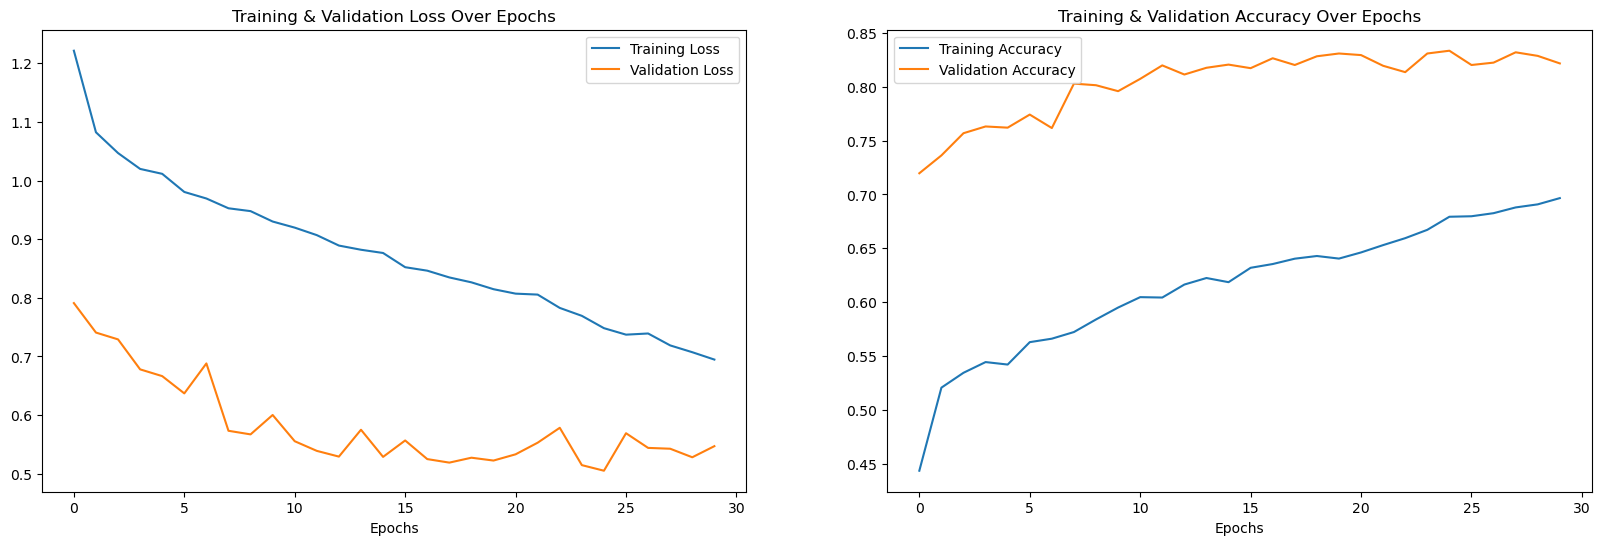

In [22]:
epochs = [i for i in range(30)]
fig, ax = plt.subplots(1,2)
train_accuracy = history.history['accuracy']
train_loss = history.history['loss']
test_accuracy = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs, train_loss, label = 'Training Loss')
ax[0].plot(epochs, test_loss, label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss Over Epochs')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs, train_accuracy, label = 'Training Accuracy')
ax[1].plot(epochs, test_accuracy, label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy Over Epochs')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [23]:
pred_test = model.predict(X_test)
y_pred = encoder.inverse_transform(pred_test)
y_test = encoder.inverse_transform(y_test)

85/85 [==============================] - 4s 47ms/step


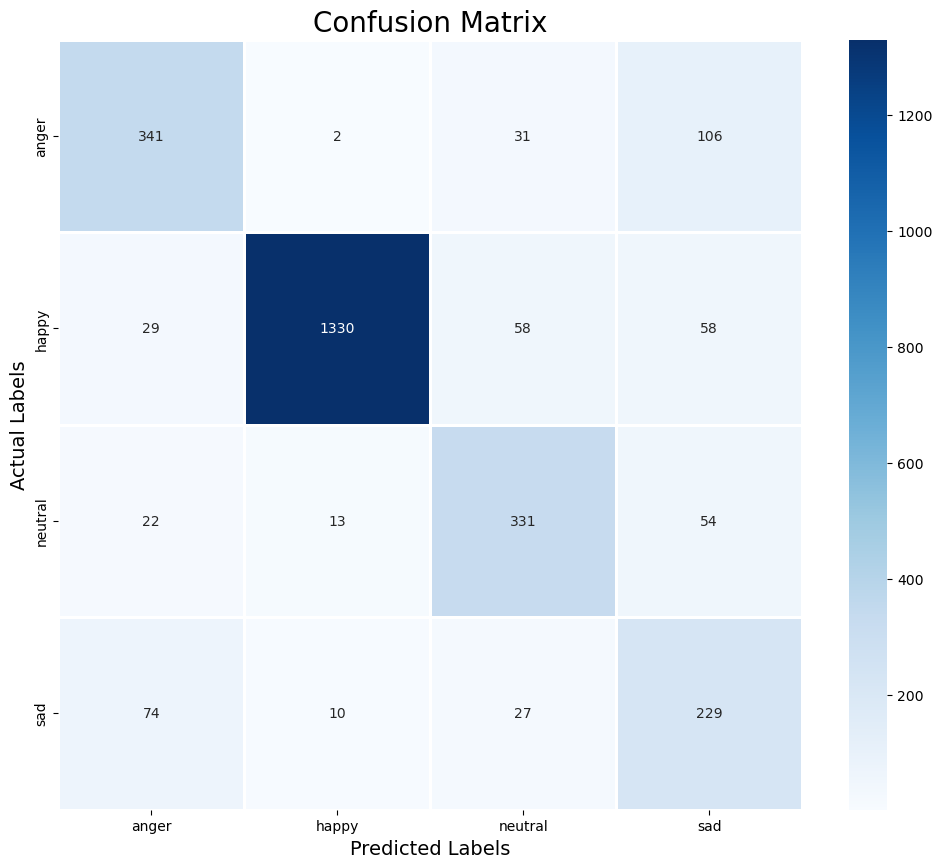

In [24]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()